In [67]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7 MB 236 kB/s 
Using legacy 'setup.py install' for en-core-web-lg, since package 'wheel' is not installed.
    Running setup.py install for en-core-web-lg ... done
You should consider upgrading via the '/work/apps/amazon_reviews_analyzer/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# Imports

In [1]:
import os
import re
import spacy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stop_words = STOP_WORDS

try:
    import en_core_web_lg
    nlp = en_core_web_lg.load()
    tokenizer = nlp.tokenizer
    tokenizer_tags = nlp
    # tokenizer_light = nlp.tokenizer
except ImportError:
    print('Using default tokenizer')
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)

# Utils

In [2]:
def token_spacy(input_text: str):
    text = input_text.lower()
    text = re.sub(r"[^A-z]", " ", text)
    
    spacy_tokens = tokenizer(text)
    tokens = [token.lemma_.strip() for token in spacy_tokens 
                    if (len(token.lemma_.strip()) > 1) and not token.lemma_.strip() in stop_words]
    
    return tokens


def token_spacy_v2(input_text: str):
    # TODO remove tags from gensim.parsing.preprocessing import strip_tags
    text = input_text.lower()
    text = re.sub(r"[^A-z('t|s)0-9]", " ", text)
    
    spacy_tokens = tokenizer(text)
    tokens = []
    for token in spacy_tokens:
        token_lemma = token.lemma_.strip().replace(u'\ufeff', '')

        if (len(token_lemma) > 1) and not token_lemma in stop_words:
            if token_lemma == '-PRON-':
                tokens.append(token.text)
            else:
                tokens.append(token_lemma)
    
    return tokens


def clear_title(text: str):
    return re.sub('([0-9]{1,} people found this helpful. Was this review helpful to you Yes No)', '', text)


def sort_n_gram(docs_vectors: list, features: list):
    sum_words = np.array(docs_vectors.sum(axis=0))[0]
    
    sorted_indexes = np.argsort(sum_words)[::-1]
    features_names = np.array(features)
     
    return np.column_stack((features_names[sorted_indexes], sum_words[sorted_indexes]))


def get_top_n_gram(corpus: np.ndarray, ngram_range: tuple=(2, 3), max_features: int=2000, n: int=20):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, tokenizer=token_spacy)
    docs_vectors = vectorizer.fit_transform(corpus)
     
    return sort_n_gram(docs_vectors, vectorizer.get_feature_names())[:n], vectorizer


def build_n_gram(vectorizer, corpus: str, n: int=20):
    docs_vectors = vectorizer.transform(corpus)
    return sort_n_gram(docs_vectors, vectorizer.get_feature_names())[:n]

# Read data

In [3]:
data_path = 'data'

In [4]:
reviews_df = pd.read_csv(os.path.join(data_path, '1429_1.csv'))
reviews_df

/work/apps/amazon_reviews_analyzer/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34655,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-09-18T00:00:00Z,NaN,2015-08-29T00:00:00Z,...,NaN,NaN,NaN,3.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...,NaN,NaN,Kris
34656,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-11-21T00:00:00Z,NaN,2015-09-02T00:00:00Z,...,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Amazon should include this charger with the Ki...,Should be included,NaN,NaN,Jonathan Stewart
34657,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-10-19T00:00:00Z,NaN,2015-09-04T00:00:00Z,...,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Love my Kindle Fire but I am really disappoint...,Disappointing Charger,NaN,NaN,J Lawson
34658,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Ser

# EDA

## Tabular data analysis

In [5]:
reviews_df.count()

id                      34660
name                    27900
asins                   34658
brand                   34660
categories              34660
keys                    34660
manufacturer            34660
reviews.date            34621
reviews.dateAdded       24039
reviews.dateSeen        34660
reviews.didPurchase         1
reviews.doRecommend     34066
reviews.id                  1
reviews.numHelpful      34131
reviews.rating          34627
reviews.sourceURLs      34660
reviews.text            34659
reviews.title           34655
reviews.userCity            0
reviews.userProvince        0
reviews.username        34658
dtype: int64

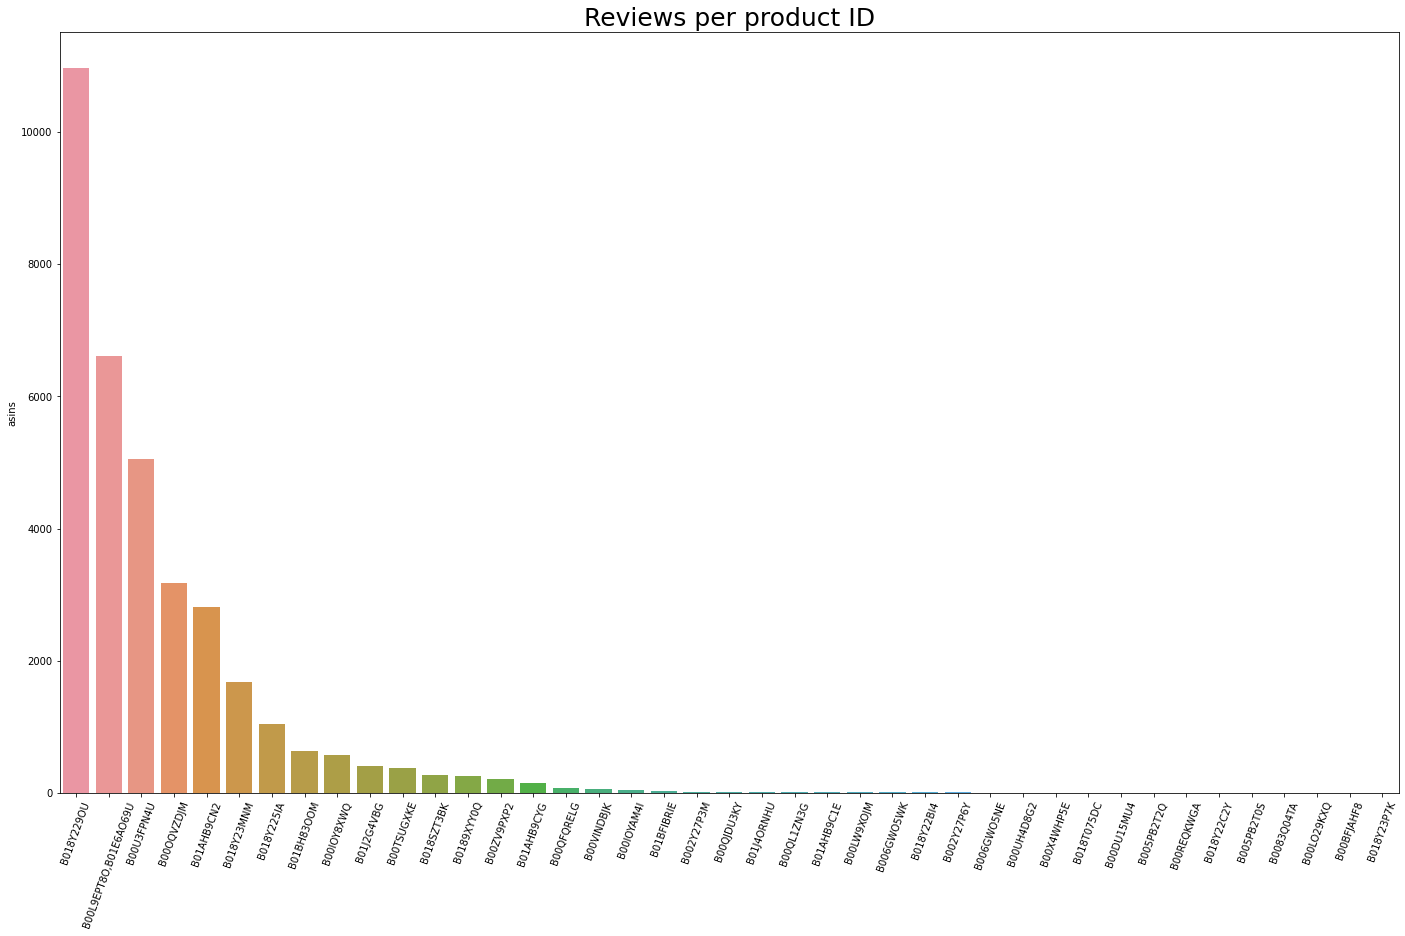

In [6]:
review_counts = reviews_df.asins.value_counts()

f, ax = plt.subplots(1,1,figsize=(24, 14))

ax.set_title('Reviews per product ID', {'fontsize': 25})

sns.barplot(x=review_counts.index, y=review_counts, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=70);

## Text analysis
exploring texts

In [7]:
for ind, row in reviews_df.iterrows():
    print('SUMMARY:',row['reviews.title'])
    print('TEXT:', row['reviews.text'] + '\n')

    if ind > 10:
        break

SUMMARY: Kindle
TEXT: This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.

SUMMARY: very fast
TEXT: great for beginner or experienced person. Bought as a gift and she loves it

SUMMARY: Beginner tablet for our 9 year old son.
TEXT: Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...

SUMMARY: Good!!!
TEXT: I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the b

In [8]:
print('Unique titles:', np.unique(reviews_df['reviews.title'].dropna()).shape[0])

Unique titles: 19767


Clear scrapped titles

In [9]:
# Remove this from initial
# 556 people found this helpful. Was this review helpful to you Yes No.
# 53 people found this helpful. Was this review helpful to you Yes No.
# 88 people found this helpful. Was this review helpful to you Yes No.

reviews_df[reviews_df.asins == 'B006GWO5NE']['reviews.title'].values[2]

'Ships With All Current Kindle Fires... 556 people found this helpful. Was this review helpful to you Yes No'

In [10]:
reviews_df = reviews_df[reviews_df['reviews.title'].notnull() & reviews_df['reviews.text'].notnull()].copy()
reviews_df['reviews.title'] = reviews_df['reviews.title'].apply(clear_title)

Combining title with main text

In [11]:
reviews_df['all_text'] = reviews_df['reviews.title'] + '. ' + reviews_df['reviews.text']
reviews_df = reviews_df[reviews_df.all_text.notnull()]

Plotting reviews length

In [12]:
texts_lengths = reviews_df['all_text'].dropna().apply(len)
print(
    f'Longest review: {texts_lengths.max()}.', 
    f'Shortest review: {texts_lengths.min()}.',
    f'Mean of reviews: {texts_lengths.mean()}',
    sep='\n'
)

Longest review: 10724.
Shortest review: 12.
Mean of reviews: 180.0941016910025


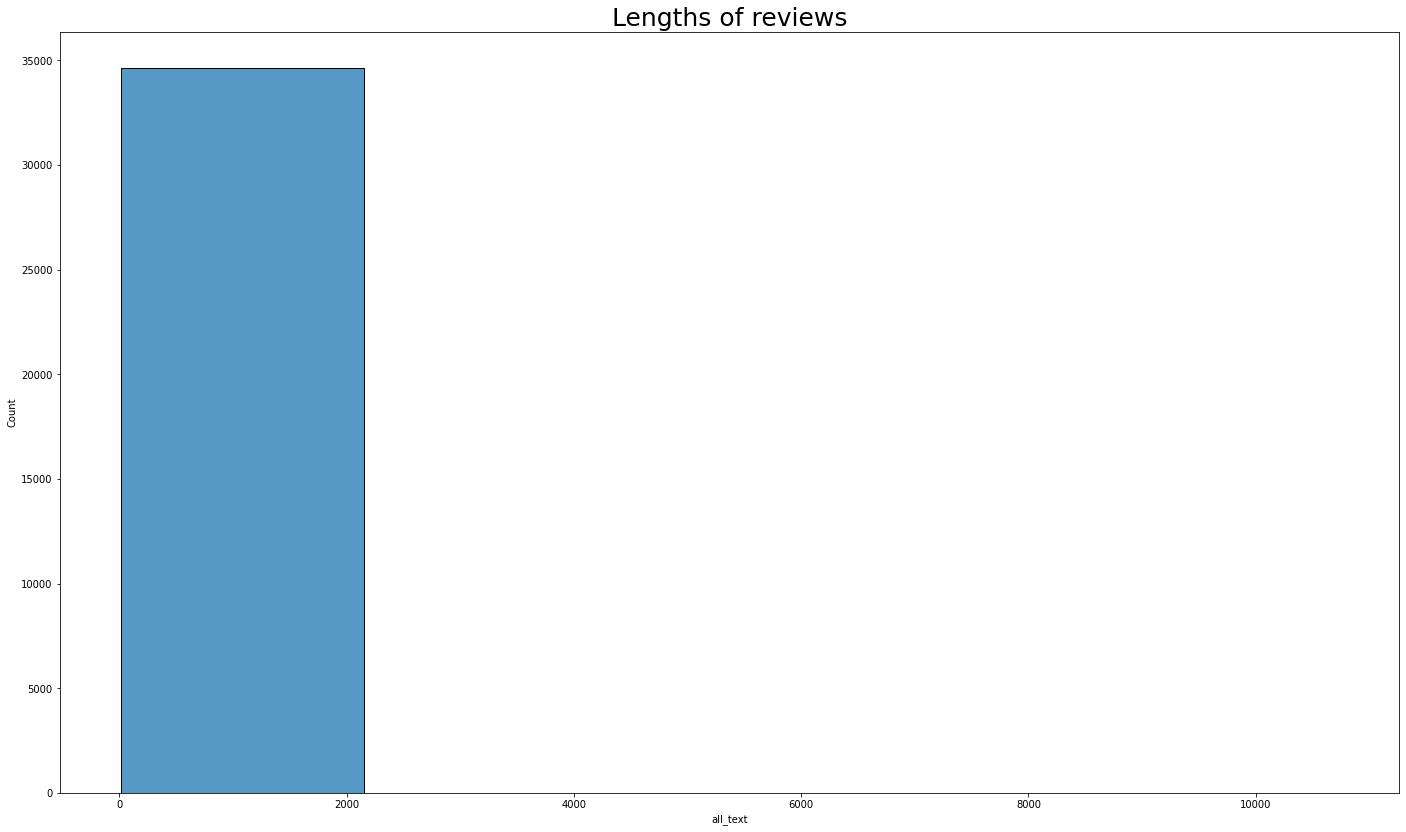

In [13]:
f, ax = plt.subplots(1,1,figsize=(24, 14))

ax.set_title('Lengths of reviews', {'fontsize': 25})
sns.histplot(texts_lengths, kde=False, bins=5, ax=ax);

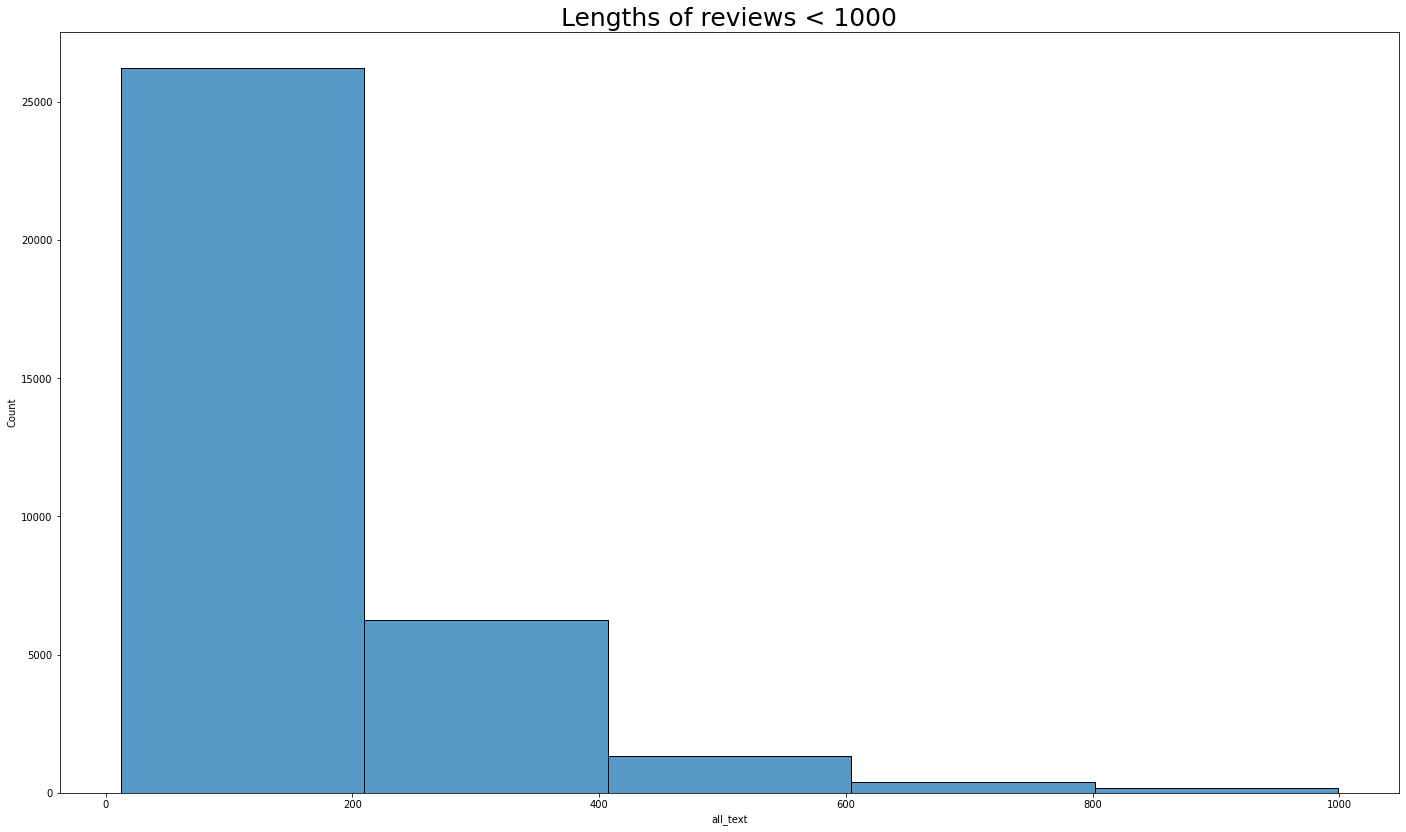

In [14]:
f, ax = plt.subplots(1,1,figsize=(24, 14))

ax.set_title('Lengths of reviews < 1000', {'fontsize': 25})
sns.histplot(texts_lengths[texts_lengths < 1000], kde=False, bins=5, ax=ax);

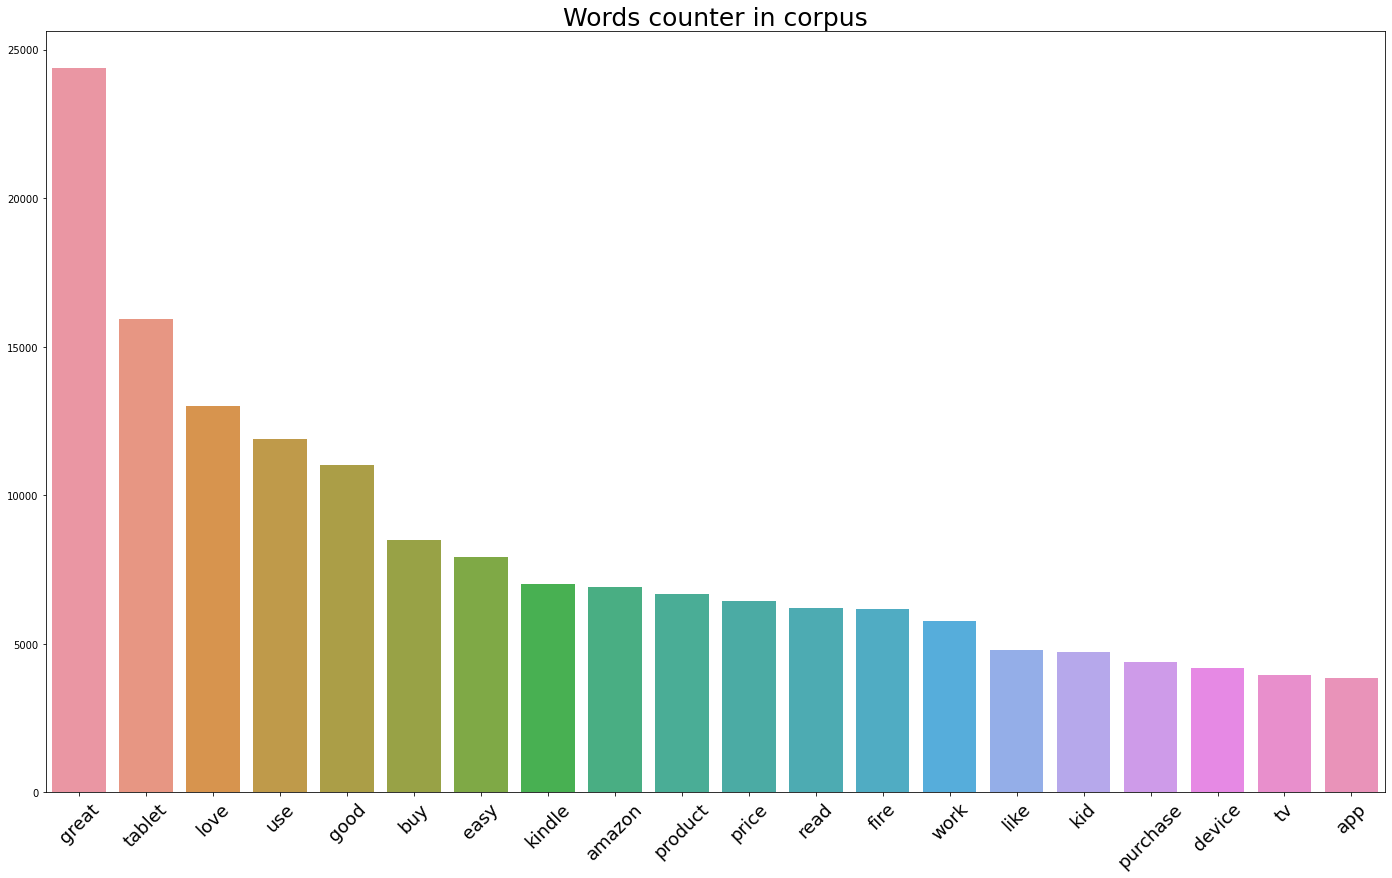

In [15]:
words_counter = Counter(token_spacy(' '.join(reviews_df['all_text'].dropna())))
top_words = np.array(tuple(words_counter.most_common(20)))

f, ax = plt.subplots(1, 1, figsize=(24, 14))

ax.set_title('Words counter in corpus', {'fontsize': 25})
sns.barplot(x=top_words[:, 0], y=top_words[:, 1].astype('int'), ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=18);

In [16]:
top_n_grams, vectorizer = get_top_n_gram(reviews_df.all_text.dropna(), n=20)
top_n_grams_df = pd.DataFrame(top_n_grams)
top_n_grams_df.columns=["bi_gram", "freq"]
top_n_grams_df.freq = top_n_grams_df.freq.astype(np.float16)

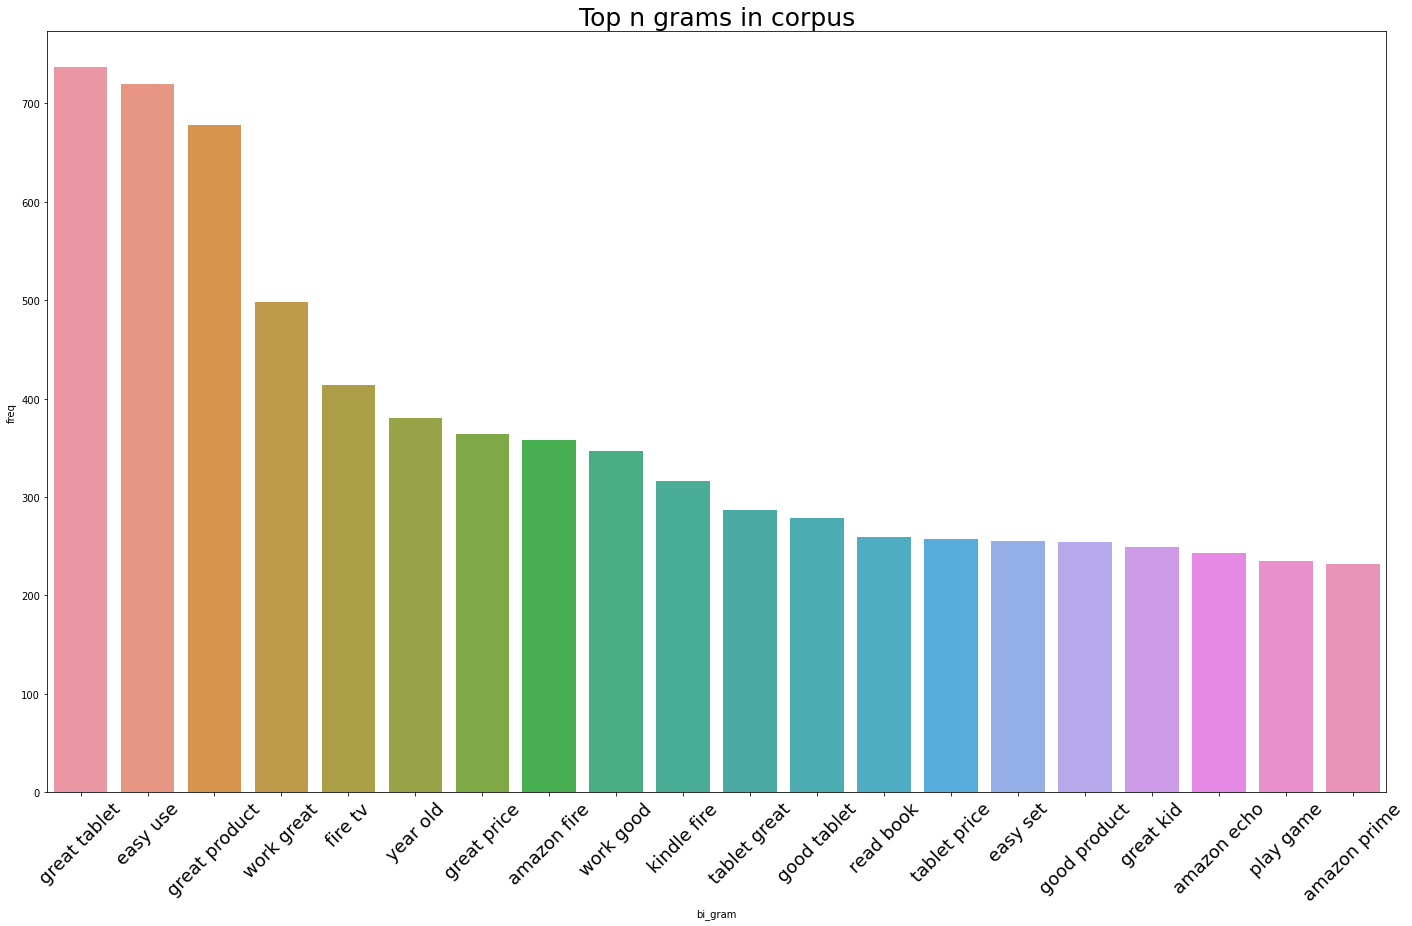

In [17]:
f, ax = plt.subplots(1,1,figsize=(24, 14))

ax.set_title('Top n grams in corpus', {'fontsize': 25})
sns.barplot(x="bi_gram", y="freq", data=top_n_grams_df, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=18);

## Build keyphrases for each product

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=2000, tokenizer=token_spacy_v2)
vectorizer.fit(reviews_df.all_text)


/work/apps/amazon_reviews_analyzer/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=2000, ngram_range=(2, 3),
                tokenizer=<function token_spacy_v2 at 0x7f95c53304d0>)

In [19]:
products_keyphrases_df = []

for ind, product_group in reviews_df.groupby('asins'):
    top_n_grams = build_n_gram(vectorizer=vectorizer, corpus=product_group.all_text, n=20)
    products_keyphrases_df.append({'asin': ind, 'keyphrases': top_n_grams[:,0],'raw_keyphrases': top_n_grams})


In [20]:
products_keyphrases_df = pd.DataFrame(products_keyphrases_df)
products_keyphrases_df

,asin,keyphrases,raw_keyphrases
0,B002Y27P3M,"[page turn, new kindle, kindle keyboard, use k...","[[page turn, 2.34234933075354], [new kindle, 1..."
1,B002Y27P6Y,"[kindle read, kindle work, it easy, work great...","[[kindle read, 1.2621111430206566], [kindle wo..."
2,B005PB2T0S,"[kindle keyboard, new kindle, feel like, kindl...","[[kindle keyboard, 1.7086062596953622], [new k..."
3,B005PB2T2Q,"[kindle touch, kindle keyboard, doe it, look l...","[[kindle touch, 1.1339104523521293], [kindle k..."
4,B006GWO5NE,"[kindle fire, need new, kindle fire hd, good k...","[[kindle fire, 1.9297370597577206], [need new,..."
5,B006GWO5WK,"[charge kindle, kindle fire, purchase kindle, ...","[[charge kindle, 2.329915134188034], [kindle f..."
6,B0083Q04TA,"[kindle fire, fire hd, year old, kindle keyboa...","[[kindle fire, 1.6981013491860775], [fire hd, ..."
7,B00BFJAHF8,"[great doe, yr old, good work good, good start...","[[great doe, 1.0], [yr old, 0.0], [good work g..."
8,B00DU15MU4,"[apple tv, easy find, prime movie, i try, amaz...","[[apple tv, 1.6966821556118379], [easy find, 1..."
9,B00IOY8XWQ,"[kindle voyage, page turn, great reader, turn ...","[[kindle voyage, 33.678076383063065], [page tu..."


In [21]:
# pos analysis
for i, (ind, product) in enumerate(products_keyphrases_df.iterrows()):
    print(f'Product {ind}. Top tags {product.keyphrases}')
    if i == 4:
        break

Product 0. Top tags ['page turn' 'new kindle' 'kindle keyboard' 'use kindle'
 'page turn button' 'turn button' 'use battery' 'reader i' 'good device'
 'book easy' 'great service' 'good light' 'kindle touch' 'touch screen'
 'great love' 'it small' 'generation kindle' 'love great' 'connect home'
 'perfect read']
Product 1. Top tags ['kindle read' 'kindle work' 'it easy' 'work great' 'new kindle'
 'hold hand' 'quality product' 'like product' 'purchase kindle'
 'recommend product' 'kindle product' 'new amazon' 'device purchase'
 'read like' 'read device' 'good kindle' 'especially price' 'start use'
 'price pay' 'replace kindle']
Product 2. Top tags ['kindle keyboard' 'new kindle' 'feel like' 'kindle light' 'size weight'
 'high quality' 'everyday use' 'buy replacement' 'version kindle'
 'new version' 'light great' 'kindle doe' 'kindle use' 'decide buy'
 'light screen' 'money buy' 'save money' 'want use' 'kindle good'
 'ease use']
Product 3. Top tags ['kindle touch' 'kindle keyboard' 'doe it

## Grouping keyphrases

### TF LDA method

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic number {topic_idx + 1}:')
        print(', '.join(
            [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        )

In [27]:
vectorizer = CountVectorizer(ngram_range=(2,3), max_features=2000, tokenizer=token_spacy_v2)
transformed_texts = vectorizer.fit_transform(reviews_df.all_text);
vectorizer.get_feature_names()[-10:], vectorizer.get_feature_names()[:10]

(['year old mother',
  'year old nephew',
  'year old son',
  'year old use',
  'year warranty',
  'you look',
  'young child',
  'young kid',
  'youtube video',
  'yr old'],
 ['10 year',
  '10 year old',
  '11 year',
  '11 year old',
  '12 year',
  '12 year old',
  '128 gb',
  '16 gb',
  '32 gb',
  '3rd kindle'])

In [28]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
lda.fit(transformed_texts);


In [29]:
# n=2,3
no_top_words = 5
display_topics(lda, vectorizer.get_feature_names(), no_top_words)

Topic number 1:
work good, amazon echo, work great, good product, great product
Topic number 2:
great gift, love alexa, excellent product, smart tv, great addition
Topic number 3:
amazon prime, easy set, easy use, highly recommend, apple tv
Topic number 4:
great stream, great buy, it great, great sound, work great
Topic number 5:
great product, fire stick, product great, easy use, easy read
Topic number 6:
easy use, great device, sound quality, great read, ask alexa
Topic number 7:
year old, stream device, good tablet, love easy, easy use
Topic number 8:
fire tv, amazon fire, amazon fire tv, play music, love echo
Topic number 9:
great tablet, great price, tablet great, kid love, tablet price
Topic number 10:
kindle fire, love kindle, love love, battery life, kindle paperwhite


In [38]:
# n=1,3
no_top_words = 5
display_topics(lda, vectorizer.get_feature_names(), no_top_words)

Topic 0:
tv, fire, amazon, fire tv, -PRON-
Topic 1:
great, product, love, great product, use
Topic 2:
easy, use, great, easy use, light
Topic 3:
box, reader, question, charge, month
Topic 4:
tablet, great, price, good, great tablet
Topic 5:
kindle, love, gift, buy, read
Topic 6:
echo, device, -PRON-, amazon, home
Topic 7:
alexa, music, play, use, game
Topic 8:
love, great, tablet, buy, year
Topic 9:
good, work, app, product, great


### TF-IDF NMF method

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), max_features=2000, tokenizer=token_spacy_v2)
transformed_texts = vectorizer.fit_transform(reviews_df.all_text);
vectorizer.get_feature_names()[-10:], vectorizer.get_feature_names()[:10]

(['year old mother',
  'year old nephew',
  'year old son',
  'year old use',
  'year warranty',
  'you look',
  'young child',
  'young kid',
  'youtube video',
  'yr old'],
 ['10 year',
  '10 year old',
  '11 year',
  '11 year old',
  '12 year',
  '12 year old',
  '128 gb',
  '16 gb',
  '32 gb',
  '3rd kindle'])

In [34]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(transformed_texts);

In [35]:
no_top_words = 5
display_topics(nmf, vectorizer.get_feature_names(), no_top_words)

Topic number 1:
great tablet, tablet price, tablet great, great tablet price, tablet kid
Topic number 2:
great product, product great, great product great, product great product, great product love
Topic number 3:
easy use, use great, love easy, easy use great, love easy use
Topic number 4:
fire tv, amazon fire, amazon fire tv, fire stick, tv box
Topic number 5:
work great, great work, great love, tablet work great, work great love
Topic number 6:
year old, old love, buy year, year old love, buy year old
Topic number 7:
work good, tablet work good, tablet work, product work good, product work
Topic number 8:
great price, tablet great, tablet great price, price great, great price great
Topic number 9:
kindle fire, love kindle, love kindle fire, read book, new kindle
Topic number 10:
good product, product good, good product good, product good product, good good


## TF-IDF NMF grouped by product

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000, tokenizer=token_spacy_v2)
vectorizer.fit(reviews_df.all_text)

/work/apps/amazon_reviews_analyzer/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=5000, ngram_range=(2, 3),
                tokenizer=<function token_spacy_v2 at 0x7f95c53304d0>)

In [136]:
vectorizer.get_feature_names()[-10:], vectorizer.get_feature_names()[:10]

(['young son',
  'youtube app',
  'youtube kid',
  'youtube netflix',
  'youtube video',
  'yr old',
  'yr old daughter',
  'yr old grandson',
  'yr old love',
  'yr old son'],
 ['10 inch',
  '10 year',
  '10 year old',
  '11 year',
  '11 year old',
  '12 year',
  '12 year old',
  '128 gb',
  '16 gb',
  '1st gen'])

Showing top 5 topics for each product

In [37]:
for i, (ind, product_group) in enumerate(reviews_df.groupby('asins')):
    print(product_group.shape)
    if product_group.shape[0] < 5:
        continue
    nmf = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
    nmf.fit(vectorizer.transform(product_group.all_text));
    
    no_top_words = 5
    print(f'\nProduct asin: {ind}')
    display_topics(nmf, vectorizer.get_feature_names(), no_top_words)

    if i == 10:
        break

(19, 22)

Product asin: B002Y27P3M
Topic number 1:
page turn, power button, read thing, dedicate reader, compare apple
Topic number 2:
kindle keyboard, kindle touch, br br, touch screen, year old kindle
Topic number 3:
new kindle, it small, generation kindle, perfect read, br br
Topic number 4:
page turn, br br, kindle store, good light, iphone ipad
Topic number 5:
buy want, read time, book easy, fit purse, yr old son
(10, 22)

Product asin: B002Y27P6Y
Topic number 1:
kindle cover, new kindle, it big, kindle read, kindle work
Topic number 2:
good fit, product want, long period, hold long, kindle product
Topic number 3:
great happy, work great, use small, way use, good price
Topic number 4:
find helpful, hold hand, quality product, yr old son, good product good
Topic number 5:
nice simple, good think, it easy, yr old son, good product good
(5, 22)

Product asin: B005PB2T0S
Topic number 1:
kindle keyboard, feel like, kindle battery, previous generation, big improvement
Topic number 2:
hi